In [1]:
import matplotlib.pyplot as plt
import numpy
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image

# np.random.seed(42)
from sklearn.metrics import confusion_matrix

import keras
import tensorflow as tf
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from scipy import stats
from sklearn.preprocessing import LabelEncoder
import cv2
from keras.models import load_model
from sklearn import svm
from sklearn.svm import SVC

In [8]:
print(keras.__version__)

RecursionError: maximum recursion depth exceeded while calling a Python object

In [3]:
model = keras.saving.load_model(os.path.join('models', 'Densenetmodel50epochs1500resample224size.keras'))

C:\Users\jesse\scoop\apps\python\current\Lib\site-packages\keras\src\saving\saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'adam', because it has 1210 variables whereas the saved optimizer has 6 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


In [66]:
trainedModel = keras.saving.load_model(os.path.join('models', 'SequentialRelu50epochs1500resample64size.keras'))

In [6]:
dataset = pd.read_csv('project_dataset/HAM10000_metadata.csv')
SIZE = 224

In [7]:
labEnc = LabelEncoder()
labEnc.fit(dataset['dx'])
LabelEncoder()

dataset['label'] = labEnc.transform(dataset["dx"])
dataset.sample(10)

,lesion_id,image_id,dx,dx_type,age,sex,localization,label
2929,HAM_0006765,ISIC_0032302,bcc,histo,60.0,female,upper extremity,1
3720,HAM_0007539,ISIC_0026875,nv,follow_up,35.0,female,upper extremity,5
3286,HAM_0006177,ISIC_0031234,nv,follow_up,45.0,male,trunk,5
3787,HAM_0003732,ISIC_0026710,nv,follow_up,65.0,female,abdomen,5
3375,HAM_0002404,ISIC_0031776,nv,follow_up,55.0,male,back,5
1144,HAM_0003110,ISIC_0026789,df,histo,65.0,male,lower extremity,3
5171,HAM_0006068,ISIC_0024591,nv,follow_up,35.0,male,back,5
7760,HAM_0003346,ISIC_0032754,nv,histo,50.0,male,chest,5
5474,HAM_0001043,ISIC_0026035,nv,follow_up,45.0,male,upper extremity,5
41,HAM_0000164,ISIC_0029161,bkl,histo,60.0,male,chest,2


In [8]:
# Dataset is imbalanced, resample the classes to remove the imbalance
ds_0 = dataset[dataset['label'] == 0]
ds_1 = dataset[dataset['label'] == 1]
ds_2 = dataset[dataset['label'] == 2]
ds_3 = dataset[dataset['label'] == 3]
ds_4 = dataset[dataset['label'] == 4]
ds_5 = dataset[dataset['label'] == 5]
ds_6 = dataset[dataset['label'] == 6]

sample_num = 500
ds_0_balanced = resample(ds_0, replace=True, n_samples=sample_num, random_state=42)
ds_1_balanced = resample(ds_1, replace=True, n_samples=sample_num, random_state=42)
ds_2_balanced = resample(ds_2, replace=True, n_samples=sample_num, random_state=42)
ds_3_balanced = resample(ds_3, replace=True, n_samples=sample_num, random_state=42)
ds_4_balanced = resample(ds_4, replace=True, n_samples=sample_num, random_state=42)
ds_5_balanced = resample(ds_5, replace=True, n_samples=sample_num, random_state=42)
ds_6_balanced = resample(ds_6, replace=True, n_samples=sample_num, random_state=42)

# Combine the datasets together
dataset_balanced = pd.concat(
    [ds_0_balanced, ds_1_balanced, ds_2_balanced, ds_3_balanced, ds_4_balanced, ds_5_balanced, ds_6_balanced])
# Check new distribution
dataset_balanced['label'].value_counts()

label
0    500
1    500
2    500
3    500
4    500
5    500
6    500
Name: count, dtype: int64

In [9]:
# Read images based on the image ID from the csv file
image_path = {os.path.splitext(os.path.basename(x))[0]: x
    for x in glob(os.path.join('all_images/', '*.jpg'))}

In [10]:
# Define the path and add as a new column
dataset_balanced['path'] = dataset['image_id'].map(image_path.get)

#use the path to read images, then convert them to 224,224 then add them to a new column called image
dataset_balanced['image'] = dataset_balanced['path'].map(lambda x: np.asarray(Image.open(x).resize((SIZE,SIZE))))

In [11]:
# Concert dataframe image attributes into a numpy array
X = np.asarray(dataset_balanced['image'].tolist())
# Scale values between 0-1 by dividing by the highest possible value (255)
X = X/255
# assign label values (what we are trying to predict) to Y, label is used instead of dx because label is an integer and the computer won't understand dx
Y = dataset_balanced['label']
# Convert to categorical as this is multiclass classification
Y_cat = to_categorical(Y,num_classes = 7)
# make training and testing partitions
# x_train, x_test, y_train, y_test = train_test_split(X, Y_cat, test_size=0.25, random_state=42)

In [55]:
# Define the path and add as a new column
dataset['path'] = dataset['image_id'].map(image_path.get)

#use the path to read images, then convert them to 224,224 then add them to a new column called image
dataset['image'] = dataset['path'].map(lambda x: np.asarray(Image.open(x).resize((SIZE,SIZE))))

In [56]:
# Concert dataframe image attributes into a numpy array
XF = np.asarray(dataset['image'].tolist())
# Scale values between 0-1 by dividing by the highest possible value (255)
XF = XF/255
# assign label values (what we are trying to predict) to Y, label is used instead of dx because label is an integer and the computer won't understand dx
YF = dataset['label']
# Convert to categorical as this is multiclass classification
YF_cat = to_categorical(YF,num_classes = 7)
# make training and testing partitions
# x_train, x_test, y_train, y_test = train_test_split(X, Y_cat, test_size=0.25, random_state=42)

In [57]:
yf_pred = model.predict(XF)

313/313 ━━━━━━━━━━━━━━━━━━━━ 430s 1s/step


In [58]:
yf_pred_maxes = []
for row in yf_pred:
    yf_pred_maxes.append(row.argmax())

In [59]:
yf_maxes = []
for row in YF_cat:
    yf_maxes.append(row.argmax())

In [60]:
from sklearn.metrics import classification_report

print(classification_report(yf_maxes,yf_pred_maxes))

              precision    recall  f1-score   support

           0       0.65      0.91      0.76       327
           1       0.61      0.90      0.73       514
           2       0.47      0.84      0.60      1099
           3       0.43      1.00      0.60       115
           4       0.48      0.71      0.58      1113
           5       0.98      0.69      0.81      6705
           6       0.78      1.00      0.88       142

    accuracy                           0.74     10015
   macro avg       0.63      0.86      0.71     10015
weighted avg       0.83      0.74      0.75     10015


In [61]:
cm = confusion_matrix(yf_maxes, yf_pred_maxes)

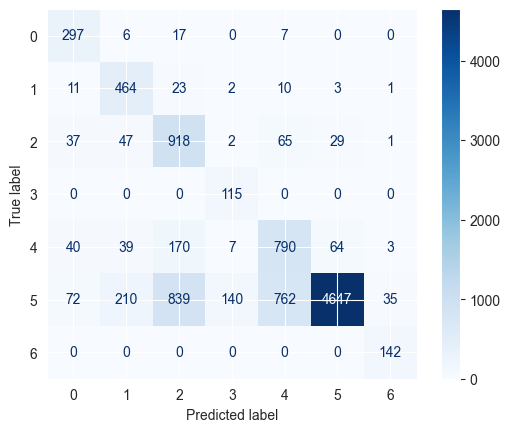

In [65]:
from sklearn import metrics
labels = np.unique(YF)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = labels)

cm_display.plot(cmap='Blues')
plt.show()
#https://www.w3schools.com/python/python_ml_confusion_matrix.asp

In [12]:
y_pred = model.predict(X)

110/110 ━━━━━━━━━━━━━━━━━━━━ 171s 1s/step


In [49]:
y_pred_maxes = []
for row in y_pred:
    y_pred_maxes.append(row.argmax())

In [51]:
y_pred_maxes[1000]

2

In [38]:
Y_cat[2000].argmax()

4

In [39]:
y_maxes = []
for row in Y_cat:
    y_maxes.append(row.argmax())

In [45]:
y_maxes

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [52]:
cm = confusion_matrix(y_maxes, y_pred_maxes)

In [53]:
cm

array([[475,   3,  16,   0,   6,   0,   0],
       [  3, 479,  14,   0,   2,   1,   1],
       [  8,  12, 465,   0,   7,   8,   0],
       [  0,   0,   0, 500,   0,   0,   0],
       [ 12,   8,  59,   1, 404,  16,   0],
       [  2,  15,  63,   0,  26, 394,   0],
       [  0,   0,   0,   0,   0,   0, 500]], dtype=int64)

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_maxes,y_pred_maxes))

In [67]:
import joblib

svm_model = joblib.load(os.path.join('models', 'svm_model.joblib'))

In [69]:
CVM_y_pred = svm_model.predict(yf_pred)

In [71]:
print(classification_report(yf_maxes,CVM_y_pred))

              precision    recall  f1-score   support

           0       0.63      0.94      0.76       327
           1       0.62      0.90      0.74       514
           2       0.54      0.78      0.64      1099
           3       0.50      1.00      0.66       115
           4       0.48      0.77      0.59      1113
           5       0.98      0.73      0.84      6705
           6       0.80      1.00      0.89       142

    accuracy                           0.76     10015
   macro avg       0.65      0.87      0.73     10015
weighted avg       0.84      0.76      0.78     10015


In [72]:
SVMcm = confusion_matrix(yf_maxes, CVM_y_pred)

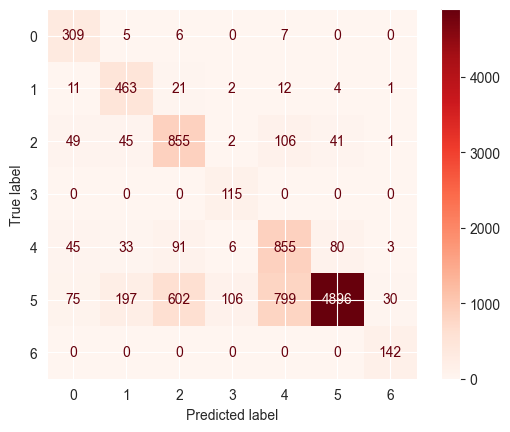

In [75]:
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = SVMcm, display_labels = labels)

cm_display.plot(cmap='Reds')
plt.show()
#https://www.w3schools.com/python/python_ml_confusion_matrix.asp

In [4]:
from tensorflow_model_optimization.quantization.keras import vitis_quantize

ImportError: Keras cannot be imported. Check that it is installed.

In [9]:
import tensorflow_model_optimization as tfmot

pruning_params = {
    'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,
                                                             final_sparsity=0.90,
                                                             begin_step=0,
                                                             end_step=2000)
}

# Apply pruning to the model
pruned_model = tfmot.sparsity.keras.prune_low_magnitude(model, **pruning_params)

RecursionError: maximum recursion depth exceeded while calling a Python object

In [14]:
#import tensorflow_model_optimization

#print(tensorflow_model_optimization.__version__)